In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import Generator

batch_size = 256
generator = Generator().manual_seed(11)

## Dataset

In [2]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('train/')
label_to_class = {v:k for k, v in dataset.class_to_idx.items()}
dataset.class_to_idx

{'baked_potato': 0,
 'baklava': 1,
 'caesar_salad': 2,
 'cheese_sandwich': 3,
 'cheesecake': 4,
 'chicken': 5,
 'chicken_curry': 6,
 'chocolate_cake': 7,
 'donuts': 8,
 'eggs': 9,
 'falafel': 10,
 'fish': 11,
 'french_fries': 12,
 'hamburger': 13,
 'hot_dog': 14,
 'ice_cream': 15,
 'lasagna': 16,
 'omelette': 17,
 'pizza': 18,
 'spaghetti': 19,
 'steak': 20,
 'sushi': 21}

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_size = int(.7 * len(dataset))
val_size = int(.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

trainset, validset, testset = random_split(dataset, [train_size, val_size, test_size], generator)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Model

In [5]:
from torch import load

model = load('resnet.pt')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Test

In [9]:
dataset.transform = model.transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


loader = testloader

incorrects = []
preds = []
gt = []

with torch.no_grad():
    for data in loader:
        images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        idxs_mask = (predicted != labels).view(-1)
        incorrects.append(images[idxs_mask].cpu())
        preds += [predicted[idxs_mask].cpu()]
        gt += [labels[idxs_mask].cpu()]

incorrects = torch.cat(incorrects)
preds = torch.cat(preds)
gt = torch.cat(gt)

print(f'Accuracy on the {len(loader.dataset)} images: {100 * (1 - len(incorrects) / len(loader.dataset)):.3f} %')

cuda:0
Accuracy on the 3614 images: 89.236 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


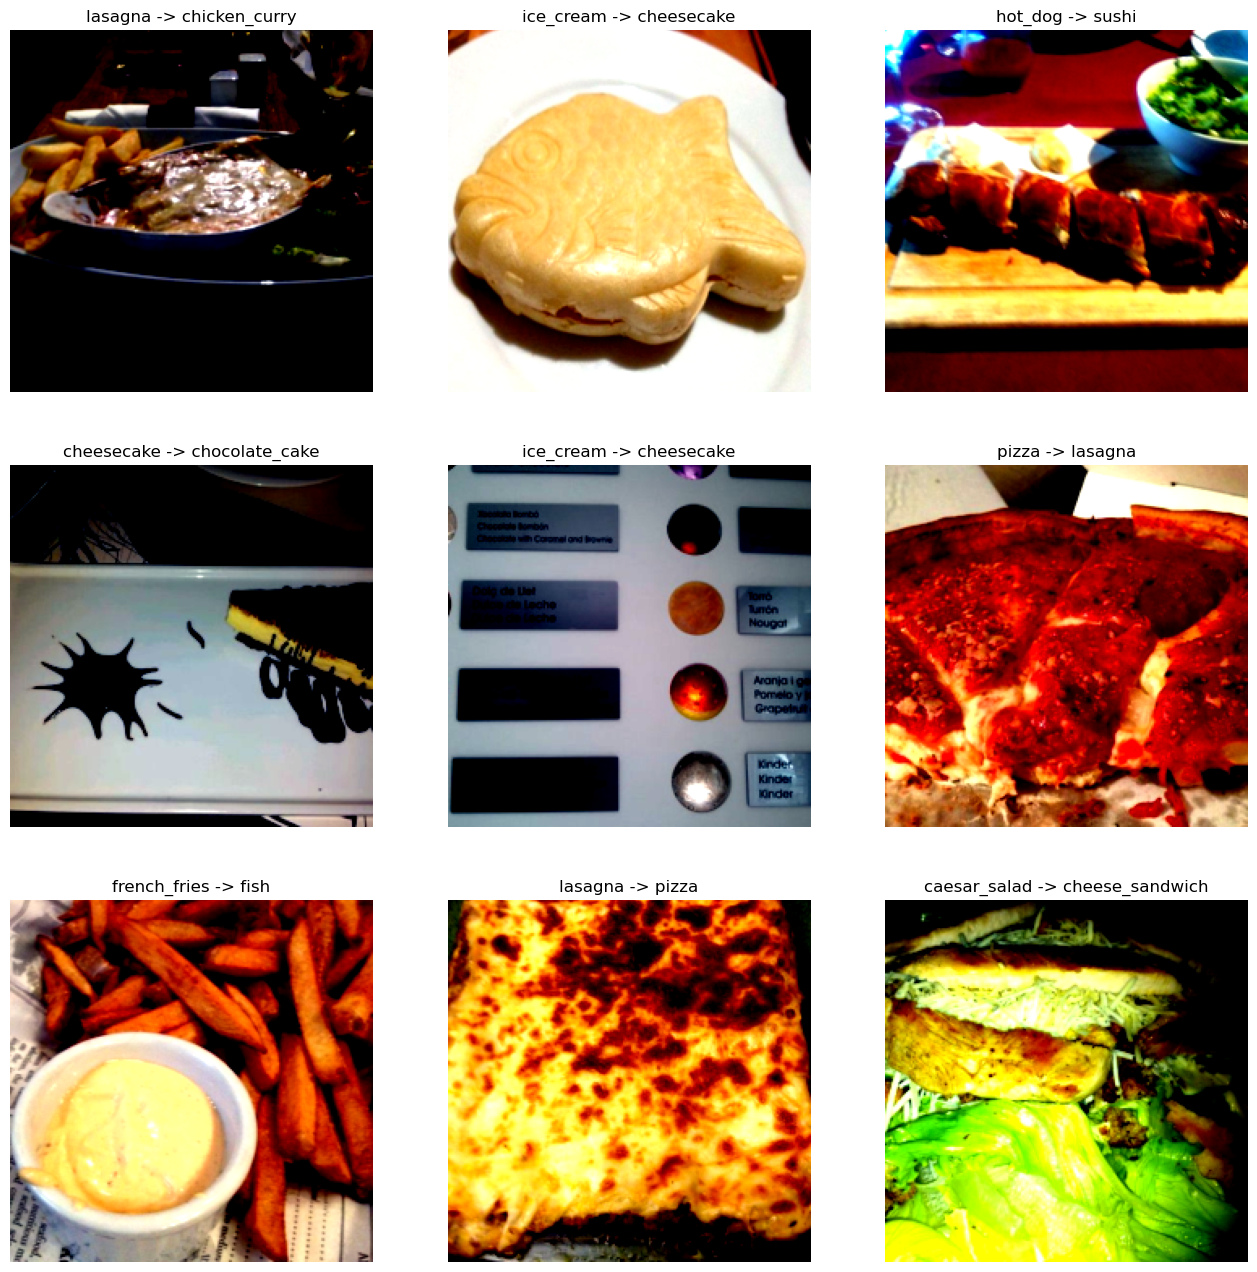

In [7]:
from torchvision.utils import make_grid


mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2)
cols, rows = 3, 3
n = rows * cols
figure = plt.figure(figsize=(16, 16))
for i in range(n):
    idx = torch.randint(len(incorrects), size=(1,)).item()
    img = incorrects[idx]
    img = img * mean + std     # unnormalize
    npimg = img.numpy()
    figure.add_subplot(rows, cols, i+1)
    plt.title(f'{label_to_class[gt[idx].item()]} -> {label_to_class[preds[idx].item()]}')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")   
plt.show()